# IMPORTS, SEEDING, AND WORK PATH

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! cp -r /content/drive/My\ Drive/DLAS/data/recordings_wav.zip /home/
! unzip /home/recordings_wav.zip -d /home/

Archive:  /home/recordings_wav.zip
   creating: /home/recordings_wav/
  inflating: /home/recordings_wav/afrikaans1.wav  
  inflating: /home/recordings_wav/afrikaans2.wav  
  inflating: /home/recordings_wav/afrikaans3.wav  
  inflating: /home/recordings_wav/afrikaans4.wav  
  inflating: /home/recordings_wav/afrikaans5.wav  
  inflating: /home/recordings_wav/agni1.wav  
  inflating: /home/recordings_wav/akan1.wav  
  inflating: /home/recordings_wav/albanian1.wav  
  inflating: /home/recordings_wav/albanian2.wav  
  inflating: /home/recordings_wav/albanian3.wav  
  inflating: /home/recordings_wav/albanian4.wav  
  inflating: /home/recordings_wav/albanian5.wav  
  inflating: /home/recordings_wav/albanian6.wav  
  inflating: /home/recordings_wav/albanian7.wav  
  inflating: /home/recordings_wav/albanian8.wav  
  inflating: /home/recordings_wav/albanian9.wav  
  inflating: /home/recordings_wav/amazigh1.wav  
  inflating: /home/recordings_wav/amazigh2.wav  
  inflating: /home/recordings_wav/a

In [3]:
import os 
import math
import random
import librosa
import librosa.display
from time import time

import csv
import scipy
import numpy as np
import pandas as pd       
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()
import IPython.display as ipd  # To play sound in the notebook

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Input, Lambda
from keras.optimizers import SGD, Adam
from keras import backend as K

# Working path
path = "/content/drive/My Drive/DLAS/data/speech-accent-archive"
os.chdir(path)
print(os.listdir())

# Consistent Seeding
SEED = 11
os.environ['PYTHONHASHSEED']= str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['recordings', 'reading-passage.txt', 'speakers_all.csv', 'speaker_info_final.csv', 'model.png', 'results', 'siamese_results_n-way (1).gsheet', 'siamese_results_n-way.gsheet', 'siamese_results_n-way.csv']


Using TensorFlow backend.


# HYPERPARAMETERS (W/O NN ARCHITECTURE)

In [0]:
# Model definition
LABEL = "age_range"
INPUT_PROCESSING = "features"
FEATURE_EXTRACTION = "log-mel"

# Audio proccessing for INPUT_PROCESSING = features
DATA_PATH = "/home/recordings_wav/"
SAMPLE_RATE = 16000
SAMPLES_PER_AUDIO = 200000 # 100.000 ~ 6 seconds
N_MFCC = 20
N_MELS = 128
COEFF = 0.15 # for noise
OFFSET = 0.2 # for shift
SPEED_RATE = 0.8 # for speed

# Data Slicing and Splitting
TEST_SPLIT = 0.2
MIN_SAMPLES_PER_LANGUAGE = 150
SLICING_STRATEGY = "unseen_samples"
# Unseen categories with no new samples from seen categories in test
# Unseen samples from each category but no new categories in test

# Model Training
TRAIN_DATA = 'train_languages'
SCALING = None # "minmax"
OPTIMIZER = Adam(0.0001, clipnorm=1.)
LOSS = 'binary_crossentropy'
N_ITER = 12000
BATCH_SIZE = 24 
REPEATING_LANGUAGES = True       
VERBOSE = True

# Model Evaluation
TEST_DATA = 'test_languages'
N_WAY = 5
TEST_BATCH = 48
TEST_ITER = 100
REPEATING_LANGUAGES_SUPPORT_SET = True 
TEST_N_WAY = 20
MEAN_TEST_BATCHES = 15

# HELP FUNCTIONS
1. Splitting Strategies for Test Set
2. Train Batch Sampling
3. Siamese Model
4. Test Batch Sampling and Evaluation
5. Loading and Processing Audios

In [0]:
# Splitting Strategies

def split_unseen_categories(sliced_languages):

  total_languages = {"train_languages": None, "test_languages": None}
  len_train_languages = int(len(sliced_languages) * (1-TEST_SPLIT))
  total_languages["train_languages"] = np.random.choice(sliced_languages, size=len_train_languages, replace=False, p=None).tolist()
  total_languages["test_languages"] = [language for language in sliced_languages if language not in total_languages["train_languages"]]

  total_languages_indeces = {"train_languages": {}, "test_languages": {}}
  for language in total_languages["train_languages"]:
    total_languages_indeces["train_languages"][language] = speakers_info.loc[speakers_info[LABEL]==language].index.to_list()
  for language in total_languages["test_languages"]:
    total_languages_indeces["test_languages"][language] = speakers_info.loc[speakers_info[LABEL]==language].index.to_list()

  # Checking if sampling is done correctly
  tmp = total_languages["train_languages"].copy()
  tmp.extend(total_languages["test_languages"])
  print("Same list?", sorted(tmp) == sliced_languages)

  # Number of samples in dataset for train and test
  print("Train real sample size:", len(speakers_info.loc[speakers_info[LABEL].isin(total_languages["train_languages"])]))
  print("Test real sample size:", len(speakers_info.loc[speakers_info[LABEL].isin(total_languages["test_languages"])]))

  return total_languages, total_languages_indeces

def split_unseen_samples(sliced_languages):

  total_languages = {"train_languages": sliced_languages, "test_languages": sliced_languages}

  total_languages_indeces = {"train_languages": {}, "test_languages": {}}
  for language in sliced_languages:
    language_indeces = speakers_info.loc[speakers_info[LABEL]==language].index.to_list()
    np.random.shuffle(language_indeces)
    len_train_language = int(len(language_indeces) * (1-TEST_SPLIT))
    total_languages_indeces["train_languages"][language] = language_indeces[:len_train_language]
    total_languages_indeces["test_languages"][language] = language_indeces[len_train_language:]

  print(total_languages["train_languages"]==total_languages["test_languages"])
  #print(total_languages_indeces["train_languages"]["basque"])
  #print(total_languages_indeces["test_languages"]["basque"])

  return total_languages, total_languages_indeces

In [0]:
# Function for sampling batches of pairs
# TODO: Use distribution with probs based on number of samples instead of uniformly sampling

def get_batch(X, languages_key, batch_size=1):

  languages = dict_languages[languages_key]
  useful_languages_indeces = dict_languages_indeces[languages_key]

  sampled_languages = np.random.choice(languages, size=batch_size, replace=REPEATING_LANGUAGES, p=None)
  left_array = []
  right_array = []
  targets = np.zeros((batch_size,))
  targets[batch_size//2:] = 1

  for i, language in enumerate(sampled_languages):

    # Left side of the pair
    index_left = np.random.randint(0, len(useful_languages_indeces[language]))
    df_index_left = useful_languages_indeces[language][index_left]
    left_array.append(X[df_index_left])

    # Right side of the pair
    # Same language
    if i >= batch_size // 2:
      index_right = np.random.randint(0, len(useful_languages_indeces[language]))
      df_index_right = useful_languages_indeces[language][index_right]
      #print("Same:", language, language)
    # Different language -> OJO sampling from sampled list
    else:
      diff_language_index = (i + np.random.randint(1, len(sampled_languages))) % len(sampled_languages)
      diff_language = sampled_languages[diff_language_index]
      index_right = np.random.randint(0, len(useful_languages_indeces[diff_language]))
      df_index_right = useful_languages_indeces[diff_language][index_right]
      #print("Different:", language, diff_language)
    right_array.append(X[df_index_right])
  
  left_array = np.expand_dims(left_array, axis=-1)
  right_array = np.expand_dims(right_array, axis=-1)

  return [left_array, right_array], np.expand_dims(targets, axis=-1)

In [0]:
# Creating the model

def big_CNN_model(input_shape):

  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.01))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.01))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.01))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.01))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(rate=0.01))

  #ipd.display(model.summary())

  return model

def small_CNN_model(input_shape):

  model = Sequential()

  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.01))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.01))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(rate=0.01))

  #ipd.display(model.summary())

  return model


def siamese_model(input_shape):

  # Define the tensors for the two input images
  left_input = Input(input_shape)
  right_input = Input(input_shape)

  # Convolutional Neural Network
  if FEATURE_EXTRACTION == "log-mel" and INPUT_PROCESSING == "features":
    model = big_CNN_model(input_shape)
  else:
    model = small_CNN_model(input_shape)

  # Generate the encodings (feature vectors) for the two images
  encoded_l = model(left_input)
  encoded_r = model(right_input)

  # Add a customized layer to compute the absolute difference between the encodings
  L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([encoded_l, encoded_r])
  
  # Add a dense layer with a sigmoid unit to generate the similarity score
  outputs = Dense(1, activation='sigmoid')(L1_distance)
  
  # Connect the inputs with the outputs
  siamese_net = Model(inputs=[left_input,right_input], outputs=outputs)
  
  # return the model
  return siamese_net

In [0]:
# Function for testing the model

def get_oneshot_pairs(X, languages_key, N):

  languages = dict_languages[languages_key]
  useful_languages_indeces = dict_languages_indeces[languages_key]

  # Getting tested language and support set of N different languages
  tested_language = np.random.choice(languages, size=1, replace=False, p=None).item()
  remaining_languages = [l for l in languages if l != tested_language]
  support_set_languages = np.random.choice(remaining_languages, size=N, replace=REPEATING_LANGUAGES_SUPPORT_SET, p=None)

  # Getting indices for the tested languafe and support set
  tested_language_indices = np.random.choice(useful_languages_indeces[tested_language], size=2, replace=False)
  support_set_indices = [np.random.choice(useful_languages_indeces[l], size=1).item() for l in support_set_languages]
  support_set_indices[0] = tested_language_indices[1] # removing the first one to put  the true label

  # Getting pairs and targets
  # Left part
  left = X[tested_language_indices[0]]
  left = left.reshape(1, *left.shape)
  left = np.repeat(left, N, axis=0)
  left = np.expand_dims(left, axis=-1)

  # Right part
  right = X[support_set_indices]
  right = np.expand_dims(right, axis=-1)

  # targets
  targets = np.zeros((N,1))
  targets[0] = 1

  return [left, right], targets

def get_max_indices(probs):
  max_value = probs.max()
  max_indices = []
  for i, p in enumerate(probs):
    if p == max_value:
      max_indices.append(i)
  return max_indices

def test_oneshot(X, languages_key, test_batch, model, N):
  n_correct_random = 0
  n_correct = 0
  for i in range(test_batch):
      inputs, targets = get_oneshot_pairs(X, languages_key, N)
      probs = model.predict_on_batch(inputs)
      max_indices = get_max_indices(probs)
      max_index = np.random.choice(max_indices, size=1, replace=False)
      if max_index == np.argmax(targets):
          n_correct+=1
      if np.random.randint(N) == np.argmax(targets):
          n_correct_random+=1
  percent_correct = (100.0 * n_correct / test_batch)
  random_percent_correct = (100.0 * n_correct_random / test_batch)
  if VERBOSE:
      #print(probs)
      #print(max_indices)
      #print(max_index)
      print("{}-way Accuracy: {}%\n".format(N, percent_correct))
  return percent_correct, random_percent_correct

def get_data_for_embedding(X, languages_key):

  languages = dict_languages[languages_key]
  useful_languages_indeces = dict_languages_indeces[languages_key]
  X_test = []
  y_test = []

  for language, indeces in useful_languages_indeces.items():
    X_test.extend(X[indeces])
    y_test.extend([language]*len(indeces))

  return np.array(X_test), np.array(y_test)

In [0]:
# Different function to load and process the audios

# Loading different data files and shuffling them along axis 1 (to keep labels ordered correctly)
def get_VGGish_embeddings():

  X_sorted = []
  X_sorted.append(np.load('recordings/audio_embeddings_hop_0.1_dur_5_offset_0.npy'))
  X_sorted.append(np.load('recordings/audio_embeddings_hop_0.1_dur_5_offset_2_5.npy'))
  X_sorted.append(np.load('recordings/audio_embeddings_hop_0.1_dur_5_offset_5.npy'))
  X_sorted.append(np.load('recordings/audio_embeddings_hop_0.1_dur_5_offset_7_5.npy'))
  X_sorted.append(np.load('recordings/audio_embeddings_hop_0.1_dur_5_offset_10.npy'))
  X_sorted = np.array(X_sorted)

  X = X_sorted.copy()
  for i in range(X_sorted.shape[1]):
    shuffle_sample = X_sorted[:,i,:,:]
    np.random.shuffle(shuffle_sample)
    X[:,i,:,:] = shuffle_sample
  
  return X_sorted[0], X

def get_audio_features(method, n_mfcc=20, n_mels=128):

  X = []
  start_time = time()
  max_nb_bit = float(2 ** (16 - 1))

  for i, audio_file in enumerate(sorted(os.listdir(DATA_PATH))):

    _, x_raw = scipy.io.wavfile.read(DATA_PATH+audio_file)
    x_raw = x_raw[:SAMPLES_PER_AUDIO]
    x = x_raw / (max_nb_bit - 1.0)

    if method == "mfcc":
      x_proccessed = librosa.feature.mfcc(y=x, sr=SAMPLE_RATE, n_mfcc=n_mfcc)
    elif method == "log-mel":
      x_melspec = librosa.feature.melspectrogram(x, sr=SAMPLE_RATE, n_mels=n_mels)
      x_proccessed = librosa.amplitude_to_db(x_melspec)
    elif method == "chroma":
      x_proccessed = librosa.feature.chroma_cqt(y=x, sr=SAMPLE_RATE)
    
    X.append(x_proccessed)
  
    if i%100==0:
      print(i, audio_file, time()-start_time)
  
  X = np.array(X)

  return np.expand_dims(X, axis=0)

def get_audio_features_and_augmentation(method, n_mfcc=20, n_mels=128):

  X = []
  start_time = time()
  max_nb_bit = float(2 ** (16 - 1))

  for i, audio_file in enumerate(sorted(os.listdir(DATA_PATH))):

    _, x_total = scipy.io.wavfile.read(DATA_PATH+audio_file)
    x_raw = x_total[:SAMPLES_PER_AUDIO]
    x_raw = x_raw / (max_nb_bit - 1.0)

    # Noise
    noise = np.random.randn(SAMPLES_PER_AUDIO) # from normal dist N(0,1)
    noise_energy = np.sqrt(noise.dot(noise) / noise.size)
    x_energy = np.sqrt(x_raw.dot(x_raw) / x_raw.size)
    x_noise = x_raw + COEFF * noise * x_energy / noise_energy

    # Shift
    audio_offset = int(OFFSET*SAMPLES_PER_AUDIO)
    x_shift = x_total[audio_offset:audio_offset+SAMPLES_PER_AUDIO]
    x_shift = x_shift / (max_nb_bit - 1.0)

    # Speed
    x_speed = librosa.effects.time_stretch(x_raw, SPEED_RATE)
    if len(x_speed) > SAMPLES_PER_AUDIO:
        x_speed = x_speed[:SAMPLES_PER_AUDIO]
    else:
        x_speed = np.pad(x_speed, (0, max(0, SAMPLES_PER_AUDIO - len(x_speed))), "constant")

    X_augmented = [x_raw, x_noise, x_shift, x_speed]
    X_audio_sample = []
    for x in X_augmented:
      if method == "mfcc":
        x_proccessed = librosa.feature.mfcc(y=x, sr=SAMPLE_RATE, n_mfcc=n_mfcc)
      elif method == "log-mel":
        x_melspec = librosa.feature.melspectrogram(x, sr=SAMPLE_RATE, n_mels=n_mels)
        x_proccessed = librosa.amplitude_to_db(x_melspec)
      elif method == "chroma":
        x_proccessed = librosa.feature.chroma_cqt(y=x, sr=SAMPLE_RATE)
      X_audio_sample.append(x_proccessed)

    X.append(X_audio_sample)
  
    if i%100==0:
      print(i, audio_file, time()-start_time)

  X = np.array(X)
  X = np.swapaxes(X,0,1)
  
  X_shuffled = X.copy()
  for i in range(X.shape[1]):
    shuffle_sample = X[:, i, :, :]
    np.random.shuffle(shuffle_sample)
    X_shuffled[:,i,:,:] = shuffle_sample
  
  return X[0], X_shuffled

# MAIN CODE

In [383]:
# Loading data
if INPUT_PROCESSING == "embeddings":
  X_test, X = get_VGGish_embeddings()
elif INPUT_PROCESSING == "features":
  X = get_audio_features(FEATURE_EXTRACTION, n_mfcc=N_MFCC, n_mels=N_MELS)
elif INPUT_PROCESSING == "features+augmentation":
  X_test, X = get_audio_features_and_augmentation(FEATURE_EXTRACTION, n_mfcc=N_MFCC, n_mels=N_MELS)

0 afrikaans1.wav 0.037328481674194336
100 arabic63.wav 3.6476776599884033
200 bulgarian12.wav 7.9445953369140625
300 dutch26.wav 12.064464330673218
400 english161.wav 15.937403202056885
500 english251.wav 19.635859489440918
600 english341.wav 23.531244039535522
700 english431.wav 27.958032608032227
800 english521.wav 32.17278027534485
900 english90.wav 36.171972036361694
1000 french48.wav 39.89998722076416
1100 gusii2.wav 43.5696234703064
1200 italian4.wav 48.756279706954956
1300 korean39.wav 53.70490050315857
1400 mandarin16.wav 58.39926552772522
1500 nepali13.wav 62.84606075286865
1600 portuguese36.wav 67.25674319267273
1700 russian5.wav 71.42389988899231
1800 spanish143.wav 75.26129364967346
1900 spanish88.wav 78.86305785179138
2000 tigrigna2.wav 82.38893270492554
2100 vietnamese22.wav 86.00025725364685


In [384]:
# Scaling data
if SCALING == "minmax":
  X = (X - X.min()) / (X.max() - X.min())
elif SCALING == "standard":
  X = (X - X.mean()) / (X.std() + np.finfo(np.float32).eps)
X.shape

(1, 2138, 128, 391)

In [385]:
# Loading info about data and fixing typos
speakers_info = pd.read_csv('speaker_info_final.csv')
speakers_info['sex'] = speakers_info['sex'].replace({'famale':'female'})

# Adding new age and native English speaker features 
bins = [0, 30, 50,np.inf]
names = ['0-30', '30-60', '60+'] #['0-18', '18-25', '25-35', '35-45', '45-55', '55-65', '65+']
speakers_info['age_range'] = pd.cut(speakers_info['age'], bins, labels=names)

speakers_info["native?"] = speakers_info["native_language"] == "english"

# Exploring info about data in general and native language in particular
print("Number of Categories")
native_language = speakers_info[LABEL].value_counts().to_frame()
ipd.display(len(native_language.loc[native_language[LABEL] >= MIN_SAMPLES_PER_LANGUAGE]))

Number of Categories


3

In [386]:
# Splitting Strategy
df_languages = speakers_info.groupby(LABEL).apply(len)
sliced_languages = df_languages.loc[df_languages>=MIN_SAMPLES_PER_LANGUAGE].index.to_list()
if SLICING_STRATEGY == "unseen_categories":
  dict_languages, dict_languages_indeces = split_unseen_categories(sliced_languages)
elif SLICING_STRATEGY == "unseen_samples":
  dict_languages, dict_languages_indeces = split_unseen_samples(sliced_languages)

True


In [394]:
# Creating Siamese Model
model = siamese_model((X[0].shape[1], X[0].shape[2], 1))
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
model.summary()

Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_75 (InputLayer)           (None, 128, 391, 1)  0                                            
__________________________________________________________________________________________________
input_76 (InputLayer)           (None, 128, 391, 1)  0                                            
__________________________________________________________________________________________________
sequential_38 (Sequential)      (None, 64)           486624      input_75[0][0]                   
                                                                 input_76[0][0]                   
__________________________________________________________________________________________________
lambda_37 (Lambda)              (None, 64)           0           sequential_38[1][0]       

In [0]:
# Training the model
train_losses = []
train_accuracies = []
test_accuracies = []
random_test_accuraccies = []
training_times = []

In [0]:
t_start = time()
VERBOSE = True
N_ITER = 1500

print("Starting training process! \n")

for i in range(1, N_ITER+1):

  rand_index = np.random.randint(X.shape[0])
  #inputs, targets = get_batch(X[rand_index], TRAIN_DATA, BATCH_SIZE)

  left, right, targets = [], [], []
  for j in range(X.shape[0]):
    [left_sample, right_sample], targets_sample = get_batch(X[j], TRAIN_DATA, BATCH_SIZE)
    left.extend(left_sample)
    right.extend(right_sample)
    targets.extend(targets_sample)
  left = np.array(left)
  right = np.array(right)
  targets = np.array(targets)
  inputs = [left, right]

  loss, train_acc = model.train_on_batch(inputs, targets)
  train_losses.append(loss)
  train_accuracies.append(train_acc)

  if i % TEST_ITER == 0:
    if VERBOSE:
      print(" ------------- \n")
      print("{0} iterations: {1} mins".format(i, (time()-t_start)/60.0))
      print("Train Loss: {0}".format(loss)) 
      print("Train Accuracy: {0}%".format(train_acc*100))
    if INPUT_PROCESSING == "features+augmentation":
      test_acc, random_test_acc = test_oneshot(X_test, TEST_DATA, TEST_BATCH, model, N_WAY)
    else:
      test_acc, random_test_acc = test_oneshot(X[rand_index], TEST_DATA, TEST_BATCH, model, N_WAY)

    test_accuracies.append(test_acc)
    random_test_accuraccies.append(random_test_acc)

training_times.append(time()-t_start)

Starting training process! 

 ------------- 

100 iterations: 0.923149049282074 mins
Train Loss: 0.7176015377044678
Train Accuracy: 45.83333432674408%
5-way Accuracy: 31.25%

 ------------- 

200 iterations: 1.8719928423563639 mins
Train Loss: 0.5932164192199707
Train Accuracy: 66.66666865348816%
5-way Accuracy: 18.75%

 ------------- 

300 iterations: 2.8203358888626098 mins
Train Loss: 0.5487590432167053
Train Accuracy: 75.0%
5-way Accuracy: 20.833333333333332%

 ------------- 

400 iterations: 3.769248636563619 mins
Train Loss: 0.6502870917320251
Train Accuracy: 62.5%
5-way Accuracy: 20.833333333333332%

 ------------- 

500 iterations: 4.718491987387339 mins
Train Loss: 0.6371629238128662
Train Accuracy: 62.5%
5-way Accuracy: 20.833333333333332%

 ------------- 

600 iterations: 5.667204809188843 mins
Train Loss: 0.5678048729896545
Train Accuracy: 87.5%
5-way Accuracy: 31.25%

 ------------- 

700 iterations: 6.615626307328542 mins
Train Loss: 0.6543431878089905
Train Accuracy: 58.

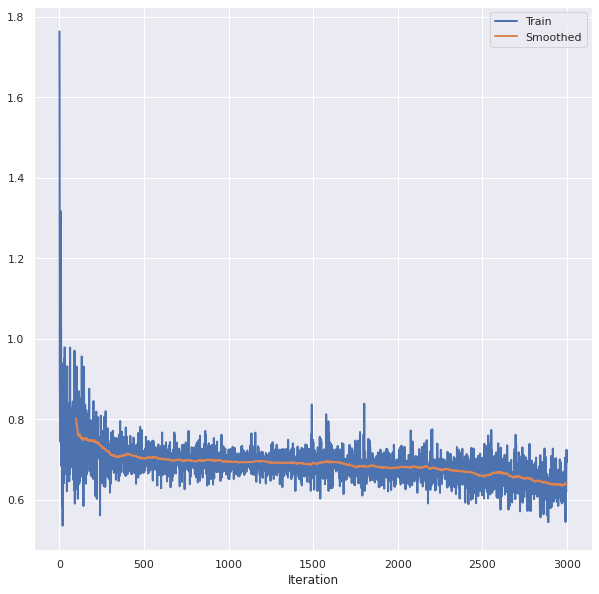

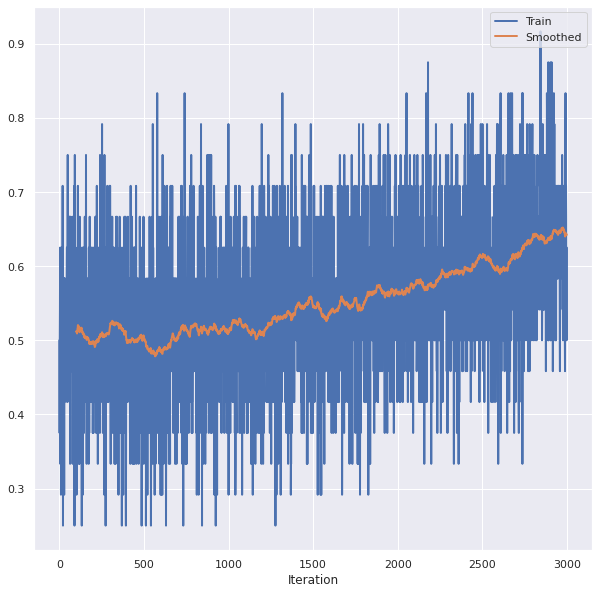

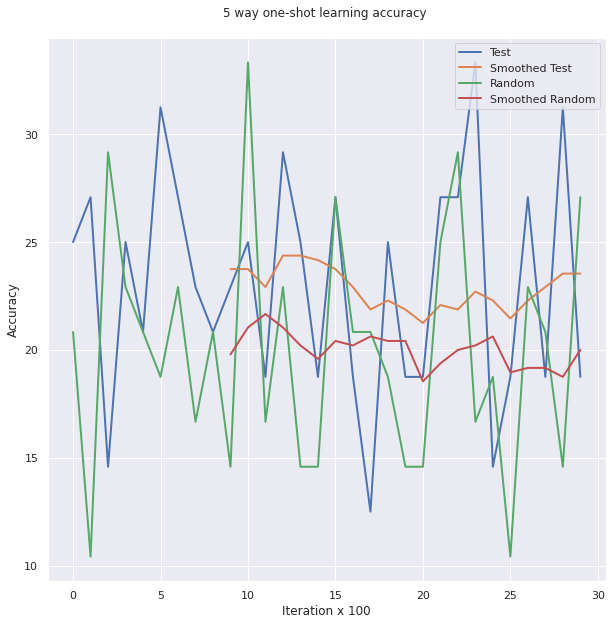

In [400]:
# Ploting loss for train and acurracy for both train and test
for i, data in enumerate([train_losses, train_accuracies]):
    plt.figure(figsize=(10,10))
    plt.plot(data, linewidth=2, label='Train')
    smoothed_data = pd.Series.rolling(pd.Series(data), 100).mean()
    plt.plot(smoothed_data, linewidth=2, label='Smoothed')
    #plt.plot(model_history['val_'+data], linewidth=2, label='Valid')
    plt.legend(loc='upper right')
    #plt.title('Model '+ data)
    #plt.ylabel(data)
    plt.xlabel('Iteration')
    plt.show()

plt.figure(figsize=(10,10))
plt.plot(test_accuracies, linewidth=2, label='Test')
smoothed_data = pd.Series.rolling(pd.Series(test_accuracies), 10).mean()
plt.plot(smoothed_data, linewidth=2, label='Smoothed Test')
plt.plot(random_test_accuraccies, linewidth=2, label='Random')
smoothed_data = pd.Series.rolling(pd.Series(random_test_accuraccies), 10).mean()
plt.plot(smoothed_data, linewidth=2, label='Smoothed Random')
plt.legend(loc='upper right')
plt.title("{} way one-shot learning accuracy \n".format(N_WAY))
plt.ylabel('Accuracy')
plt.xlabel('Iteration x {}'.format(TEST_ITER))
plt.show()

In [1]:
# Computing test acurracy for array of different n-ways
N_way_test_acc = []
N_way_random_acc = []
VERBOSE = False
TEST_N_WAY = 10
MEAN_TEST_BATCHES = 15

print("Training time so far: {} min".format(sum(training_times)/60.0))

for n in range(2,TEST_N_WAY+1):

  n_test_acc = []
  n_random_acc = []

  for i in range(MEAN_TEST_BATCHES):
    if INPUT_PROCESSING == "features+augmentation":
      test_acc, random_test_acc = test_oneshot(X_test, TEST_DATA, TEST_BATCH, model, n)
    else:
      rand_index = np.random.randint(X.shape[0])
      test_acc, random_test_acc = test_oneshot(X[rand_index], TEST_DATA, TEST_BATCH, model, n)
    n_test_acc.append(test_acc)
    n_random_acc.append(random_test_acc)
  
  test_acc = sum(n_test_acc) / len(n_test_acc)
  random_acc = sum(n_random_acc) / len(n_random_acc)

  N_way_test_acc.append(test_acc)
  N_way_random_acc.append(random_acc)

  print("{}-way test accuracy: {}, random accuracy: {}".format(n, test_acc, random_acc))

NameError: ignored

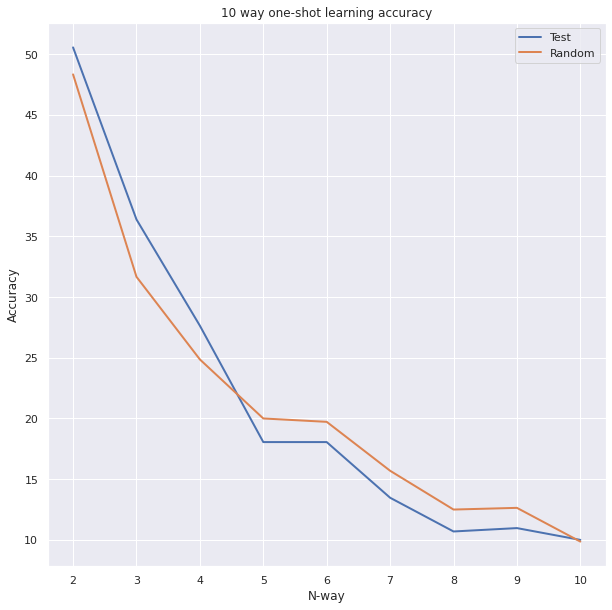

In [380]:
# Ploting test acurracy for array of different n-ways
plt.figure(figsize=(10,10))
plt.plot(list(range(2,TEST_N_WAY+1)), N_way_test_acc, linewidth=2, label='Test')
plt.plot(list(range(2,TEST_N_WAY+1)), N_way_random_acc, linewidth=2, label='Random')
plt.legend(loc='upper right')
plt.title("{} way one-shot learning accuracy".format(TEST_N_WAY))
plt.ylabel('Accuracy')
plt.xlabel('N-way')
plt.show()

In [0]:
if INPUT_PROCESSING in ["features+augmentation", "embeddings"]:
  X_test, y_test = get_data_for_embedding(X_test, TEST_DATA)
else:
  X_test, y_test = get_data_for_embedding(X[0], TEST_DATA)

In [364]:
layer_index = -3
embedding_model = Model(inputs=model.input,
                        outputs=model.get_layer(index=layer_index).get_output_at(-1))
embedding_output = embedding_model.predict([np.expand_dims(X_test, -1), np.expand_dims(X_test, -1)])
scaler = StandardScaler()
embedding_output = scaler.fit_transform(embedding_output)
embedding_output.shape

(428, 64)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 428 samples in 0.002s...
[t-SNE] Computed neighbors for 428 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 428 / 428
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.584274
[t-SNE] KL divergence after 1000 iterations: 1.553106


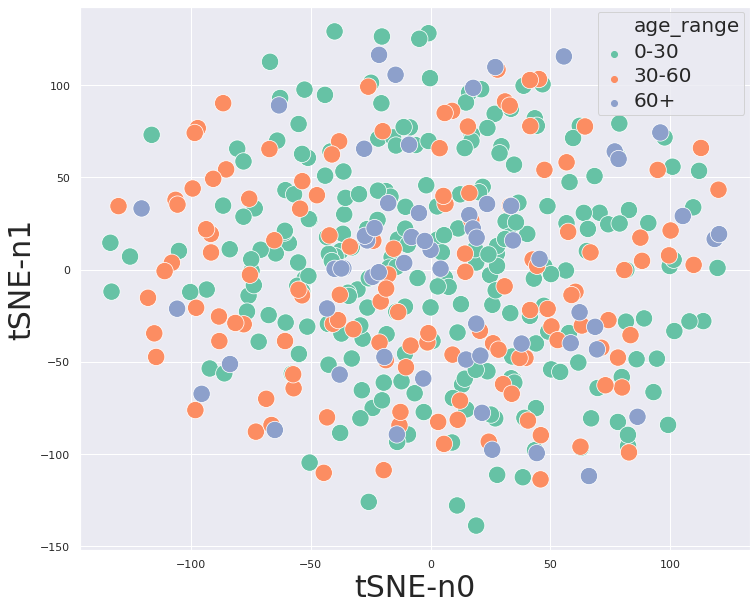

In [367]:
PLOT_LABEL = LABEL
STRATEGY = "tSNE"

### t-SNE ###
if STRATEGY == "tSNE":
  tsne = TSNE(n_components=3, verbose=1, perplexity=20, n_iter=1000)
  data_3D = tsne.fit_transform(embedding_output)

### PCA ###
if STRATEGY == "pca":
  pca = PCA(3) 
  data_3D = pca.fit_transform(embedding_output)
  print('Number of components: ' + str(pca.n_components_))
  print('Explained variation per principal component:\n' + str(pca.explained_variance_ratio_))

df_ = pd.DataFrame()
df_[STRATEGY+'-n0'] = data_3D[:,0]
df_[STRATEGY+'-n1'] = data_3D[:,1] 
df_[STRATEGY+'-n2'] = data_3D[:,2]
y_label = speakers_info[PLOT_LABEL].values
df_[PLOT_LABEL] = pd.Series(y_test).apply(str)

### 2D PLOT ###
plt.figure(figsize=(12,10))
ax = sns.scatterplot(
    x=STRATEGY+'-n0', y=STRATEGY+'-n1',
    hue=PLOT_LABEL,
    palette="Set2",
    data=df_,
    s=300
)
ax.set_xlabel(STRATEGY+'-n0',fontsize=30)
ax.set_ylabel(STRATEGY+'-n1',fontsize=30)
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='30') # for legend title
plt.show()

In [368]:
### 3D PLOT ###
fig = px.scatter_3d(df_,
                    x=STRATEGY+'-n0',
                    y=STRATEGY+'-n1',
                    z=STRATEGY+'-n2',
                    color=PLOT_LABEL,
                    symbol=PLOT_LABEL
                   )
fig.update_traces(marker=dict(size=3))
fig.show()

In [0]:
# Ploting test acurracy for array of different n-ways
COMMENT = ""

with open("siamese_results_n-way.csv", 'a') as file:
        writer = csv.writer(file, delimiter=',')
        writer.writerow([LABEL, INPUT_PROCESSING, FEATURE_EXTRACTION, COMMENT, sum(training_times), *N_way_test_acc])

# OTHERS

In [0]:
aaaa = np.array([
                  [
                    [[0,1,2], [0,1,2], [0,1,2], [0,1,2]],
                    [[3,4,5], [3,4,5], [3,4,5], [3,4,5]],
                    [[6,7,8], [6,7,8], [6,7,8], [6,7,8]]],
                  [
                    [[0,-1,-2], [0,-1,2], [0,-1,-2], [0,-1,-2]],
                    [[-3,-4,-5], [-3,-4,-5], [-3,-4,-5], [-3,-4,-5]],
                    [[-6,-7,-8], [-6,-7,-8], [-6,-7,-8], [-6,-7,-8]]]
               ])
shuffle_aaaa = np.zeros(aaaa.shape)
for i in range(aaaa.shape[1]):
  shuffle_a = aaaa[:,i,:,:]
  np.random.shuffle(shuffle_a)
  shuffle_aaaa[:,i,:,:] = shuffle_a
shuffle_aaaa

In [0]:
%%time
a = scipy.io.wavfile.read(DATA_PATH+'afrikaans1.wav')
a = a[1][:SAMPLES_PER_AUDIO]
max_nb_bit = float(2 ** (16 - 1))
aaa = a / (max_nb_bit - 1.0)

CPU times: user 18 µs, sys: 2.04 ms, total: 2.06 ms
Wall time: 6.93 ms


In [0]:
%%time
bbb, _ = librosa.load(DATA_PATH+'afrikaans1.wav', sr=16000)
bbb = bbb[:SAMPLES_PER_AUDIO]

CPU times: user 11.5 ms, sys: 33.8 ms, total: 45.3 ms
Wall time: 150 ms


In [0]:
max(aaa-bbb)

2.22304169519294e-05

In [0]:
aaa = scipy.io.wavfile.read(DATA_PATH+'afrikaans1.wav')
aaa = aaa[1][:SAMPLES_PER_AUDIO]
max_nb_bit = float(2 ** (16 - 1))
aaa = aaa / (max_nb_bit - 1.0)

In [0]:
coeff = 0.1
noise = np.random.randn(SAMPLES_PER_AUDIO) # from normal dist N(0,1)
noise_energy = np.sqrt(noise.dot(noise) / noise.size)
aaa_energy = np.sqrt(aaa.dot(aaa) / aaa.size)
bbb = aaa + coeff * noise * aaa_energy / noise_energy

In [0]:
ipd.Audio(aaa, rate=16000)

In [0]:
ipd.Audio(bbb, rate=16000)

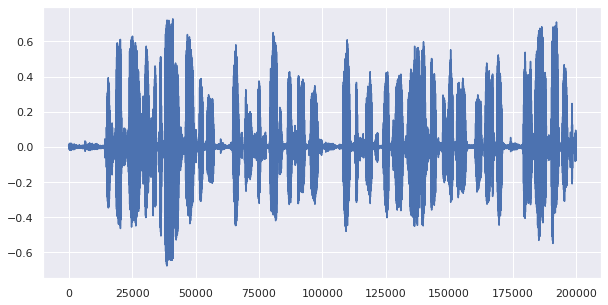

In [0]:
plt.figure(figsize=(10,5))
plt.plot(aaa)

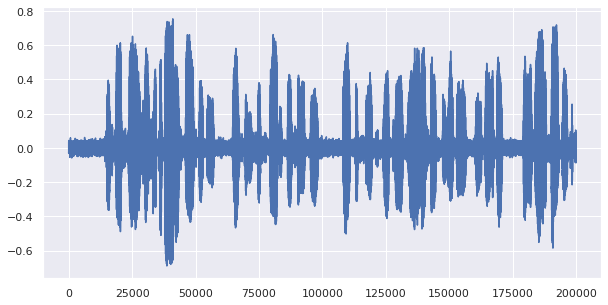

In [0]:
plt.figure(figsize=(10,5))
plt.plot(bbb)

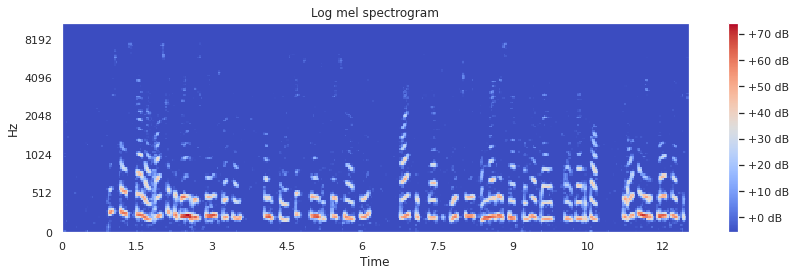

In [0]:
melspec = librosa.feature.melspectrogram(bbb, sr=SAMPLE_RATE, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.amplitude_to_db(melspec)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

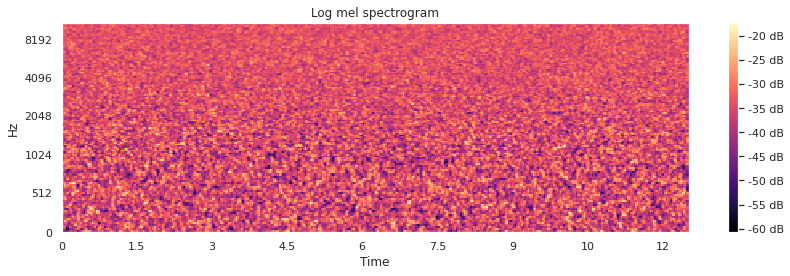

In [0]:
melspec = librosa.feature.melspectrogram(aaa-bbb, sr=SAMPLE_RATE, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.amplitude_to_db(melspec)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

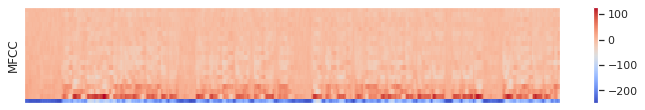

In [0]:
SAMPLE_RATE = 16000
mfcc = librosa.feature.mfcc(y=bbb, sr=SAMPLE_RATE, n_mfcc = 20) # 5 MFCC components

plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

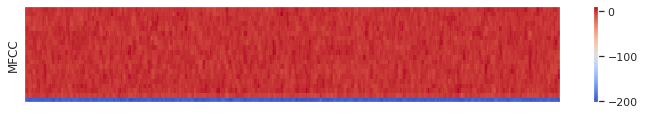

In [0]:
SAMPLE_RATE = 16000
mfcc = librosa.feature.mfcc(y=aaa-bbb, sr=SAMPLE_RATE, n_mfcc = 20) # 5 MFCC components

plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

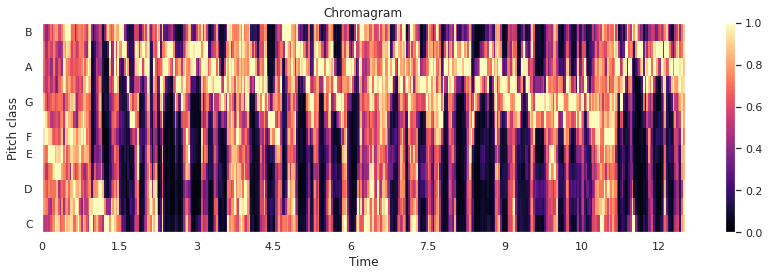

In [0]:
SAMPLE_RATE = 16000
C = librosa.feature.chroma_cqt(y=bbb, sr=SAMPLE_RATE)

plt.figure(figsize=(12,4))
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=SAMPLE_RATE, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chromagram')
plt.colorbar()
plt.tight_layout()

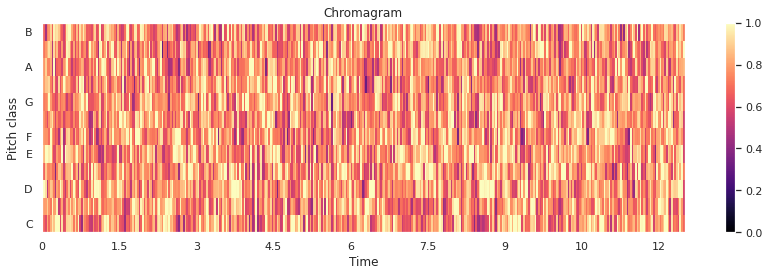

In [0]:
SAMPLE_RATE = 16000
C = librosa.feature.chroma_cqt(y=bbb-aaa, sr=SAMPLE_RATE)

plt.figure(figsize=(12,4))
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=SAMPLE_RATE, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chromagram')
plt.colorbar()
plt.tight_layout()

In [0]:
# stretching the sound
def stretch(data, rate=1):
    data = librosa.effects.time_stretch(data, rate)
    if len(data)>SAMPLES_PER_AUDIO:
        data = data[:SAMPLES_PER_AUDIO]
    else:
        data = np.pad(data, (0, max(0, SAMPLES_PER_AUDIO - len(data))), "constant")
    return data
ccc = stretch(aaa, 1.33333)
ccc.shape

(200000,)

In [0]:
ipd.Audio(ccc, rate=16000)

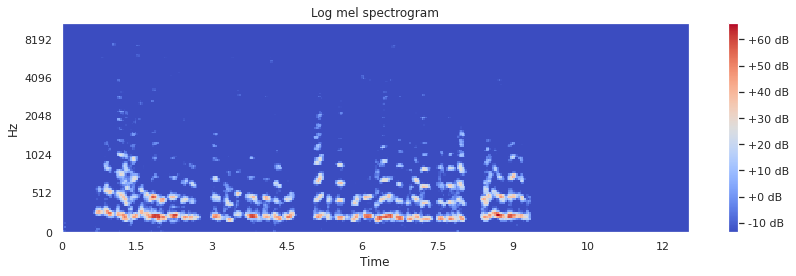

In [0]:
melspec = librosa.feature.melspectrogram(ccc, sr=SAMPLE_RATE, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.amplitude_to_db(melspec)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

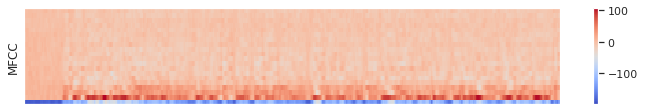

In [0]:
SAMPLE_RATE = 16000
mfcc = librosa.feature.mfcc(y=ccc-bbb, sr=SAMPLE_RATE, n_mfcc = 20) # 5 MFCC components

plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

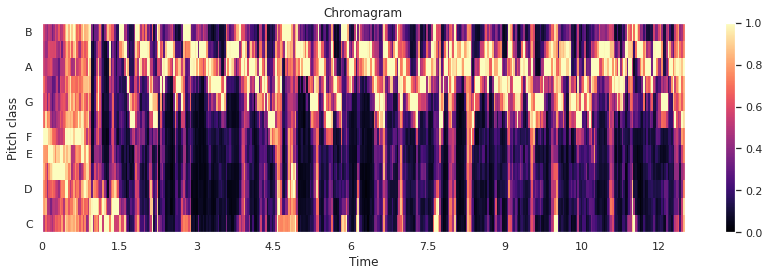

In [0]:
SAMPLE_RATE = 16000
C = librosa.feature.chroma_cqt(y=ccc-bbb, sr=SAMPLE_RATE)

plt.figure(figsize=(12,4))
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=SAMPLE_RATE, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chromagram')
plt.colorbar()
plt.tight_layout()

In [0]:
X.shape

(5, 2138, 41, 128)

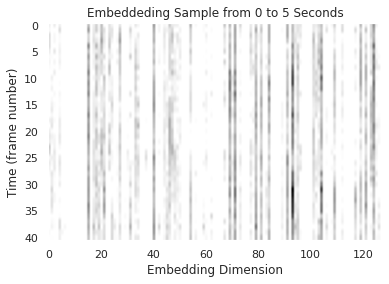

In [0]:
plt.imshow(X[0,0], 
           aspect='auto', cmap='binary')
plt.xlabel('Embedding Dimension')
plt.ylabel('Time (frame number)')
plt.title('Embeddeding Sample from 0 to 5 Seconds')
plt.grid(False);

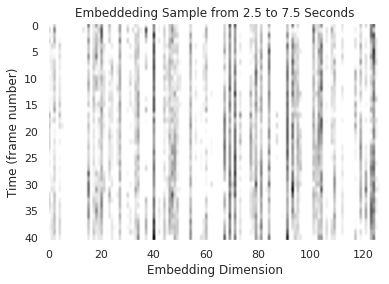

In [0]:
plt.imshow(X[1,0], 
           aspect='auto', cmap='binary')
plt.xlabel('Embedding Dimension')
plt.ylabel('Time (frame number)')
plt.title('Embeddeding Sample from 2.5 to 7.5 Seconds')
plt.grid(False);

In [0]:
# Checking if embeddings order is equal to csv info order (to get labels correctly)
speakers_info = speakers_info.sort_values('file_name')
speakers_info["filename_wav"] = speakers_info["file_name"].apply(lambda x: x.split(".")[0]+".wav")
wav_files_from_df = speakers_info["filename_wav"].tolist()
wav_files_from_drive = list(sorted(os.listdir("recordings/recordings_wav")))
print("Same order?", wav_files_from_df == wav_files_from_drive)